# Lab 3: Alignment-based metrics in Machine Learning

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A lab session from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn import datasets
from tslearn.metrics import dtw, soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

# Data loading

**Question #1.** Using the [`CachedDatasets`](https://tslearn.readthedocs.io/en/stable/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets)
utility from ``tslearn``, load the "Trace" time series dataset.
What are the dimensions of an array storing a time series dataset?
Create a new dataset `X_subset` made of 50 random time series from classes indexed 1 to 3 (`y_train < 4`)
in the training set.

In [137]:
data_loader = datasets.CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")


In [5]:
print(X_train.shape)
print(y_train.shape)

(100, 275, 1)
(100,)


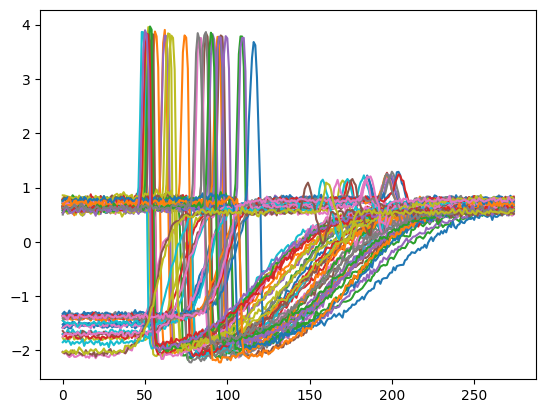

In [6]:
X_subset=X_train[y_train<4]
np.random.shuffle(X_subset)
for ts in X_subset:
    plt.plot(ts[:,0])

# $k$-means clustering

**Question #2.** Implement the Lloyd's algorithm for a $k$-means that would use soft-DTW as 
its base metric.
You can rely on ``tslearn`` functions (see imports above) for "distance" computations and barycenter
estimation.
Your function should return both the current assignments and the barycenters.
Check that it runs smoothly for a few iterations on `X_subset` (leave quantitative evaluation aside for now).

In [64]:
def kmeans_soft_dtw(X, gamma, k, max_iter=10):
    n_timeseries, n_timestamps, n_features = X.shape
    np.random.seed(20230117)
    # Init barycenters at random
    barycenters = X[np.random.randint(n_timeseries, size=k)]

    for e in range(max_iter):
        # Assign a cluster to each time series
        assign = np.zeros((n_timeseries, ), dtype=int)
        for i in range(n_timeseries):
            dist=[soft_dtw(X[i],barycenters[j],gamma) for j in range(k)]
            assign[i] = np.argmin(dist)
        # Update centroids (barycenters) for each cluster
        for j in range(k):
            # TODO
            barycenters[j] = softdtw_barycenter(X[assign==j],gamma)
    
    return assign, barycenters



In [66]:
assign_soft,barycenters_soft=kmeans_soft_dtw(X_subset,1,3)

In [39]:
barycenters_soft.shape

(3, 275, 1)

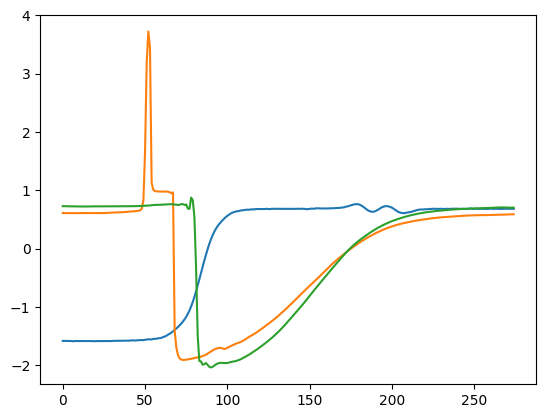

In [38]:
for ts in barycenters_soft:
    plt.plot(ts[:,0])

**Question #3.** Implement the Lloyd's algorithm for a $k$-means that would use **DTW** as 
its base metric.
You can rely on ``tslearn`` functions (see imports above) for "distance" computations and barycenter
estimation.
Your function should return both the current assignments and the barycenters.
Check that it runs smoothly for a few iteration on `X_subset` (leave quantitative evaluation aside for now).

In [65]:
def kmeans_dtw(X, k, max_iter=10):
    n_timeseries, n_timestamps, n_features = X.shape
    np.random.seed(20230117)
    # Init barycenters at random
    barycenters = X[np.random.randint(n_timeseries, size=k)]

    for e in range(max_iter):
        # Assign a cluster to each time series
        assign = np.zeros((n_timeseries, ), dtype=int)
        for i in range(n_timeseries):
            dist=[dtw(X[i],barycenters[j]) for j in range(k)]
            assign[i] = np.argmin(dist)
        # Update centroids (barycenters) for each cluster
        for j in range(k):
            # TODO
            barycenters[j] = dtw_barycenter_averaging(X[assign==j])
    
    return assign, barycenters

In [67]:
assign_dtw,barycenters_dtw=kmeans_dtw(X_subset,3)

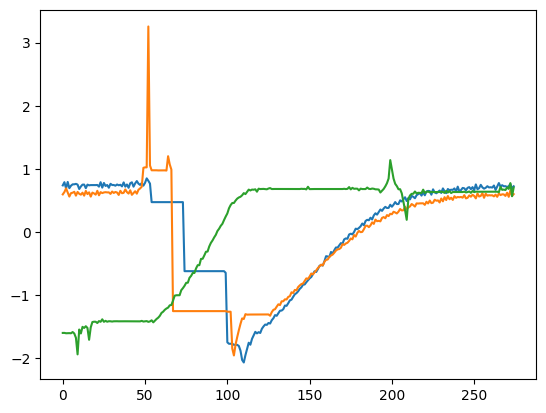

In [53]:
for ts in barycenters_dtw:
    plt.plot(ts[:,0])

**Question #4.** Implement a function that would assess the quality of a clustering in terms of 
intra-cluster inertia, computed using **DTW** as the base metric.
Your function should take a time series dataset, corresponding assignments and barycenters as inputs.

In [56]:
len(barycenters_soft)

3

In [69]:
def dtw_cost(X, assign, barycenters):
    n_timeseries, n_timestamps, n_features = X.shape
    total_cost = 0.
    for j in range(len(barycenters)):
        total_cost+= np.sum([dtw(point,barycenters[j])**2 for point in X[assign==j] ])
    
    return total_cost


In [70]:
print(dtw_cost(X_subset,assign_soft,barycenters_soft))
print(dtw_cost(X_subset,assign_dtw,barycenters_dtw))

265.486912830269
372.7922768381579


**Question #5.** Compare your $k$-means implementations in terms of DTW inertia.
For a fair comparison, make sure that they are initialized similarly, by appropriately setting your
random number generator seeds.
What do you observe? Is that expected / Do you have an explanation for that?

# Multi-step ahead forecasting

In this section, your goal will be to implement a single-hidden-layer perceptron for time series forecasting.
Your network will be trained to minimize normalized soft-DTW[^1].

To do so, we will rely on a (very nice!) `torch`-compatible implementation of soft-DTW obtained from 
[github](https://github.com/Maghoumi/pytorch-softdtw-cuda) 
(the corresponding file is already added to this project).

The code below is an implementation of a generic Multi-Layer-Perceptron class in `torch`, and you will rely on it for your implementation of a forecasting MLP with softDTW loss.

[^1]: Normalized soft-DTW (also coined soft-DTW divergence) between time series $\mathbf{x}$ and 
$\mathbf{x}^\prime$ is defined as: 
$$\text{soft-DTW}(\mathbf{x}, \mathbf{x}^\prime) - \frac{1}{2} \left( \text{soft-DTW}(\mathbf{x}, \mathbf{x}) + \text{soft-DTW}(\mathbf{x}^\prime, \mathbf{x}^\prime) \right)$$


In [1]:
import torch

In [7]:
import torch
from torch import nn

class MultiLayerPerceptron(torch.nn.Module):  # No hidden layer here
    def __init__(self, layers, loss=None):
        # At init, we define our layers
        super(MultiLayerPerceptron, self).__init__()
        self.layers = layers
        if loss is None:
            self.loss = torch.nn.MSELoss(reduction="none")
        else:
            self.loss = loss
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
            

    def forward(self, X):
        # The forward method informs about the forward pass: how one computes outputs of the network
        # from the input and the parameters of the layers registered at init
        if not isinstance(X, torch.Tensor):
            X = torch.Tensor(X)
        batch_size = X.size(0)
        X_reshaped = torch.reshape(X, (batch_size, -1))  # Manipulations to deal with time series format
        output = self.layers(X_reshaped)
        return torch.reshape(output, (batch_size, -1, 1))  # Manipulations to deal with time series format
    
    def fit(self, X, y, max_epochs=10):
        # The fit method performs the actual optimization
        X_torch = torch.Tensor(X)
        y_torch = torch.Tensor(y)

        for e in range(max_epochs):
            self.optimizer.zero_grad()
            # Forward pass
            y_pred = self.forward(X_torch)
            # Compute Loss
            loss = self.loss(y_pred, y_torch).mean()
            if e % 20 == 0:
                print('Epoch {}: train loss: {}'.format(e, loss.item()))
            # Backward pass
            loss.backward()
            self.optimizer.step()

# Example definition of a MLP model using the class above
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=3),
        nn.ReLU()
    )
)
#model.fit(X, y, max_epochs=100)  # Here one needs to define what X and y are, obviously

**Question #6.** Take inspiration from the code above to define an MLP class that would allow training
a single-hidden-layer model using normalized soft-DTW as a criterion to be optimized.
Train your network for 200 epochs on a forecasting task that would consist, given the first 150 elements
of a time series, in predicting the next 125 ones.

In [15]:
X_totrain=X_train[:,:150,:]
X_tbf=X_train[:,150:,:]

In [107]:
from soft_dtw_cuda import SoftDTW
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    )#,loss= SoftDTW(False,gamma=.1,normalize=True)
)
model.fit(X_totrain,X_tbf,max_epochs=10000)



Epoch 0: train loss: 0.5745594501495361
Epoch 20: train loss: 0.5607994794845581
Epoch 40: train loss: 0.547682523727417
Epoch 60: train loss: 0.5351583361625671
Epoch 80: train loss: 0.523171603679657
Epoch 100: train loss: 0.5116815567016602
Epoch 120: train loss: 0.5006425976753235
Epoch 140: train loss: 0.49002397060394287
Epoch 160: train loss: 0.4798010587692261
Epoch 180: train loss: 0.4699452817440033
Epoch 200: train loss: 0.4604301452636719
Epoch 220: train loss: 0.45123571157455444
Epoch 240: train loss: 0.44233500957489014
Epoch 260: train loss: 0.433704137802124
Epoch 280: train loss: 0.42532122135162354
Epoch 300: train loss: 0.41717055439949036
Epoch 320: train loss: 0.4092397689819336
Epoch 340: train loss: 0.40151527523994446
Epoch 360: train loss: 0.39398476481437683
Epoch 380: train loss: 0.38663214445114136
Epoch 400: train loss: 0.3794475495815277
Epoch 420: train loss: 0.3724263608455658
Epoch 440: train loss: 0.36555707454681396
Epoch 460: train loss: 0.358827352

Epoch 4340: train loss: 0.03465026617050171
Epoch 4360: train loss: 0.03451994061470032
Epoch 4380: train loss: 0.03439101204276085
Epoch 4400: train loss: 0.03426341339945793
Epoch 4420: train loss: 0.03413711115717888
Epoch 4440: train loss: 0.03401206061244011
Epoch 4460: train loss: 0.03388833627104759
Epoch 4480: train loss: 0.03376586735248566
Epoch 4500: train loss: 0.03364457190036774
Epoch 4520: train loss: 0.033524416387081146
Epoch 4540: train loss: 0.03340546786785126
Epoch 4560: train loss: 0.03328777477145195
Epoch 4580: train loss: 0.03317125141620636
Epoch 4600: train loss: 0.03305574879050255
Epoch 4620: train loss: 0.032941341400146484
Epoch 4640: train loss: 0.03282803297042847
Epoch 4660: train loss: 0.03271578252315521
Epoch 4680: train loss: 0.03260451555252075
Epoch 4700: train loss: 0.03249428793787956
Epoch 4720: train loss: 0.03238502889871597
Epoch 4740: train loss: 0.032276757061481476
Epoch 4760: train loss: 0.03216943517327309
Epoch 4780: train loss: 0.032

Epoch 8860: train loss: 0.019995545968413353
Epoch 8880: train loss: 0.019961899146437645
Epoch 8900: train loss: 0.019928401336073875
Epoch 8920: train loss: 0.019895056262612343
Epoch 8940: train loss: 0.0198618583381176
Epoch 8960: train loss: 0.0198287945240736
Epoch 8980: train loss: 0.019795872271060944
Epoch 9000: train loss: 0.019763097167015076
Epoch 9020: train loss: 0.0197304617613554
Epoch 9040: train loss: 0.019697973504662514
Epoch 9060: train loss: 0.01966562680900097
Epoch 9080: train loss: 0.019633427262306213
Epoch 9100: train loss: 0.0196013692766428
Epoch 9120: train loss: 0.01956944726407528
Epoch 9140: train loss: 0.019537651911377907
Epoch 9160: train loss: 0.019505904987454414
Epoch 9180: train loss: 0.019474299624562263
Epoch 9200: train loss: 0.019442832097411156
Epoch 9220: train loss: 0.019411487504839897
Epoch 9240: train loss: 0.019380278885364532
Epoch 9260: train loss: 0.019349198788404465
Epoch 9280: train loss: 0.019318239763379097
Epoch 9300: train lo

**Question #7.** Use the following code block to qualitatively assess quality of your 
network's predictions.
Do not hesitate to change the time series index to visualize the result for different time series.

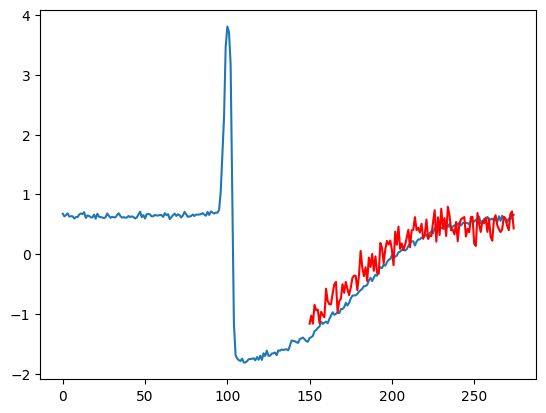

In [122]:
import matplotlib.pyplot as plt
import random
ts_index = random.randint(0,X_test.shape[0]-1)

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

# Shapelet models

Shapelet models are time series classifiers that rely on the presence/absence of local shapes in 
time series to make predictions.
These models will be presented in more details later in the course, since they can be seen as a variant of 
shallow convolutional models for time series.

In the following, you will train such models (using their 
[`tslearn` implementation](https://tslearn.readthedocs.io/en/stable/gen_modules/shapelets/tslearn.shapelets.LearningShapelets.html#tslearn.shapelets.LearningShapelets)) 
and visualize their learned decision boundaries.
For the sake of visualization, models made of only 2 local shapes will be learned, and the following 
function will be used to visualize them:

In [148]:
from matplotlib import cm

def visualize_shapelet_model_2_shapelets(model, X, y):
    distances = model.transform(X)

    plt.figure()
    viridis = cm.get_cmap('viridis', 4)
    # Create a scatter plot of the 2D distances for the time series of each class.
    for i, yi in enumerate(np.unique(y)):
        plt.scatter(distances[y == yi][:, 0],
                    distances[y == yi][:, 1],
                    color=viridis(i / 3),
                    edgecolors='k',
                    label='Class {}'.format(yi))

    # Create a meshgrid of the decision boundaries
    xmin = np.min(distances[:, 0]) - 0.1
    xmax = np.max(distances[:, 0]) + 0.1
    ymin = np.min(distances[:, 1]) - 0.1
    ymax = np.max(distances[:, 1]) + 0.1
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) / 200), 
                         np.arange(ymin, ymax, (ymax - ymin) / 200))
    
    weights, biases = model.get_weights('classification')
    Z = []
    for x, y in np.c_[xx.ravel(), yy.ravel()]:
        Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                            for i in range(4)]))
    Z = np.array(Z).reshape(xx.shape)
    plt.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

    plt.legend()
    plt.xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
    plt.ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.title('Distance transformed time series')
    plt.show()

Let us start with a first attempt.
The following code snippet defines a model made of 2 shapelets (=local shapes to be learnt) and train
them (as well as the corresponding linear decision boundaries) for 500 epochs:

In [127]:
from tslearn.shapelets import LearningShapelets

shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=1,                     # Do not print information on the evolution of the loss
    scale=False,
    random_state=42
)
shp_clf.fit(X_train, y_train)

/Users/steindijkstra/miniforge3/envs/machinelearning/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
2023-01-23 11:44:44.002008: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


LearningShapelets(max_iter=500, n_shapelets_per_size={20: 2}, random_state=42)

**Question #8.** Visualize the obtained decision boundaries. 
Would you expect this model to be a decent classifier?

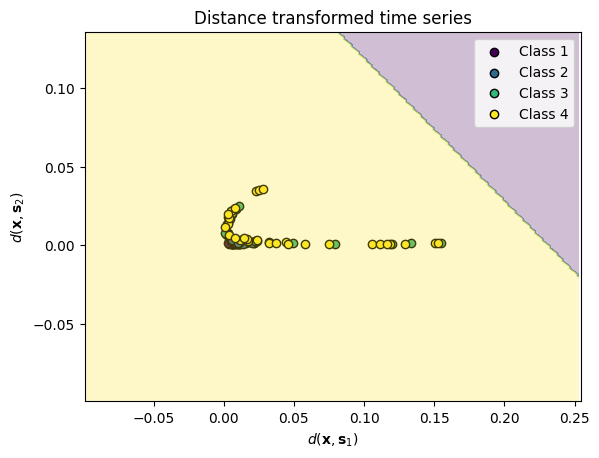

In [129]:
visualize_shapelet_model_2_shapelets(shp_clf, X_train, y_train)

**Question #9.** Shapelet models usually benefit from scaling of the input time series 
(yet this is, of course, very dataset-specific).
See if this helps in our case.

In [130]:
shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=1,                     # Do not print information on the evolution of the loss
    scale=True,
    random_state=42
)
shp_clf.fit(X_train, y_train)

Epoch 1/500
1/1 [==============================] - 0s 198ms/step - loss: 1.4330 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4330
Epoch 2/500
1/1 [==============================] - 0s 4ms/step - loss: 1.4329 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4329
Epoch 3/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4327 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4327
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4326 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4326
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4325 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4325
Epoch 6/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4324 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4324
Epoch 7/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4323 - categorical_accuracy: 0.3100 - categorical_crossentrop

1/1 [==============================] - 0s 5ms/step - loss: 1.4270 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4270
Epoch 58/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4270 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4270
Epoch 59/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4269 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4269
Epoch 60/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4268 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4268
Epoch 61/500
1/1 [==============================] - 0s 4ms/step - loss: 1.4267 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4267
Epoch 62/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4266 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4266
Epoch 63/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4265 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.426

1/1 [==============================] - 0s 5ms/step - loss: 1.4222 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4222
Epoch 114/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4221 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4221
Epoch 115/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4221 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4221
Epoch 116/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4220 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4220
Epoch 117/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4219 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4219
Epoch 118/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4218 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4218
Epoch 119/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4217 - categorical_accuracy: 0.3100 - categorical_crossentropy:

1/1 [==============================] - 0s 5ms/step - loss: 1.4182 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4182
Epoch 170/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4181 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4181
Epoch 171/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4181 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4181
Epoch 172/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4180 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4180
Epoch 173/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4179 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4179
Epoch 174/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4179 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4179
Epoch 175/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4178 - categorical_accuracy: 0.3100 - categorical_crossentropy:

1/1 [==============================] - 0s 5ms/step - loss: 1.4148 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4148
Epoch 226/500
1/1 [==============================] - 0s 4ms/step - loss: 1.4148 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4148
Epoch 227/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4147 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4147
Epoch 228/500
1/1 [==============================] - 0s 4ms/step - loss: 1.4147 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4147
Epoch 229/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4146 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4146
Epoch 230/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4146 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4146
Epoch 231/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4145 - categorical_accuracy: 0.3100 - categorical_crossentropy:

1/1 [==============================] - 0s 6ms/step - loss: 1.4120 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4120
Epoch 282/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4119 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4119
Epoch 283/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4119 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4119
Epoch 284/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4118 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4118
Epoch 285/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4118 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4118
Epoch 286/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4117 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4117
Epoch 287/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4117 - categorical_accuracy: 0.3100 - categorical_crossentropy:

1/1 [==============================] - 0s 5ms/step - loss: 1.4095 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4095
Epoch 338/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4094 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4094
Epoch 339/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4094 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4094
Epoch 340/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4093 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4093
Epoch 341/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4093 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4093
Epoch 342/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4093 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4093
Epoch 343/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4092 - categorical_accuracy: 0.3100 - categorical_crossentropy:

1/1 [==============================] - 0s 5ms/step - loss: 1.4073 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4073
Epoch 394/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4072 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4072
Epoch 395/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4072 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4072
Epoch 396/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4072 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4072
Epoch 397/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4071 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4071
Epoch 398/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4071 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4071
Epoch 399/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4070 - categorical_accuracy: 0.3100 - categorical_crossentropy:

1/1 [==============================] - 0s 4ms/step - loss: 1.4053 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4053
Epoch 450/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4053 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4053
Epoch 451/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4053 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4053
Epoch 452/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4052 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4052
Epoch 453/500
1/1 [==============================] - 0s 4ms/step - loss: 1.4052 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4052
Epoch 454/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4052 - categorical_accuracy: 0.3100 - categorical_crossentropy: 1.4052
Epoch 455/500
1/1 [==============================] - 0s 5ms/step - loss: 1.4051 - categorical_accuracy: 0.3100 - categorical_crossentropy:

LearningShapelets(max_iter=500, n_shapelets_per_size={20: 2}, random_state=42,
                  scale=True, verbose=1)

1/1 [==============================] - 0s 43ms/step


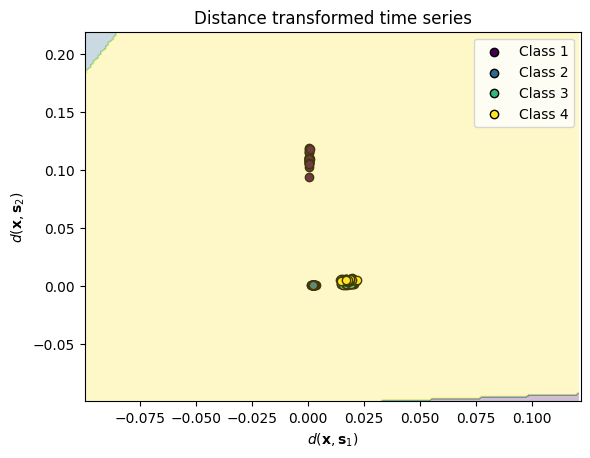

In [131]:
visualize_shapelet_model_2_shapelets(shp_clf, X_train, y_train)

**Question #10.** By default, the `tslearn` implementation uses SGD as an optimizer.
See if using `"adam"` helps in our case.

In [132]:
shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=0,                     # Do not print information on the evolution of the loss
    scale=True,
    random_state=42,
    optimizer="adam"
)
shp_clf.fit(X_train, y_train)

LearningShapelets(max_iter=500, n_shapelets_per_size={20: 2}, optimizer='adam',
                  random_state=42, scale=True)

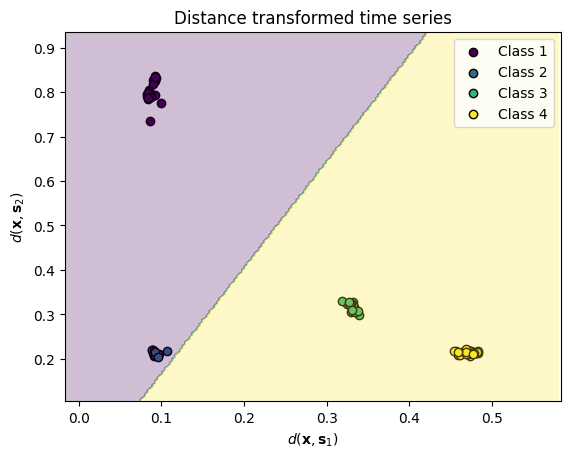

In [133]:
visualize_shapelet_model_2_shapelets(shp_clf, X_train, y_train)

**Question #11.** Set the learning rate of the Adam optimizer to 1e-2 
(you will need to import the `Adam` class from `keras` as follows) and see if this improves the learning.

In [134]:
from tensorflow.keras.optimizers import Adam

In [156]:
shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=0,                     # Do not print information on the evolution of the loss
    scale=True,
    random_state=42,
    optimizer=Adam(learning_rate=0.01)
)
shp_clf.fit(X_train, y_train)

LearningShapelets(max_iter=500, n_shapelets_per_size={20: 2},
                  optimizer=<keras.optimizers.optimizer_experimental.adam.Adam object at 0x29ec4b3d0>,
                  random_state=42, scale=True)

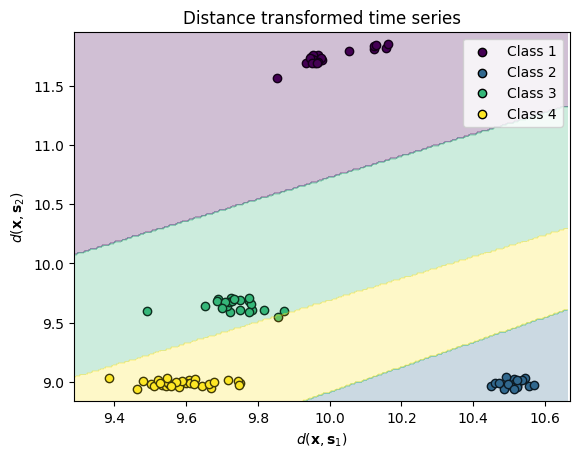

In [157]:
visualize_shapelet_model_2_shapelets(shp_clf, X_train, y_train)